# Zoll Patient Monitor
## IAP data extraction
## Comparison with NIRS data

Simo Mäkelä  
Helsinki Metropolia University of Applied Sciences  
21.8.2020

In [573]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [574]:
datafile = "data/AR18F032727-20200113-114412-690.json"

In [575]:
data = {}
with open(datafile, "r") as fd:
    data = json.load(fd)

In [576]:
zoll_record = data['ZOLL']['FullDisclosure'][0]['FullDisclosureRecord']

In [577]:
wave_records = [] # contains objects of type ContinWaveRec
trend_reports = [] # contains objects of type TrendRpt

for item in zoll_record:
    for key in item:
        if key == "ContinWaveRec":
            wave_records.append(item['ContinWaveRec'])
        if key == "TrendRpt":
            trend_reports.append(item['TrendRpt'])

print(len(wave_records), "ContinWaveRec items found.")
print(len(trend_reports), "TrendRpt items found.")
# json.dumps(trend_reports[50])
# json.dumps(wave_records[0])


1062 ContinWaveRec items found.
136 TrendRpt items found.


In [578]:
ibp_s = []
ibp_m = []
ibp_d = []
pulse = []
timestamps = []
for report in trend_reports:
    ibp_s.append(report['Trend']['Ibp'][0]['Sys']['TrendData']['Val']['#text'])
    ibp_m.append(report['Trend']['Ibp'][0]['Map']['TrendData']['Val']['#text'])
    ibp_d.append(report['Trend']['Ibp'][0]['Dia']['TrendData']['Val']['#text'])
    pulse.append(report['Trend']['Hr']['TrendData']['Val']['#text'])
    timestamps.append(pd.to_datetime(report['StdHdr']['DevDateTime'].partition('T')[2])) # ignore date, only use time
# print(pulse)
# print(timestamps)

In [579]:
df = pd.DataFrame(pulse, columns=['P'])
df['MAP'] = ibp_m
df['SAP'] = ibp_s
df['DAP'] = ibp_d
df['Time'] = timestamps
df = df.set_index('Time')
df = df.replace({
    "P":-21846
    }, np.nan)
# df

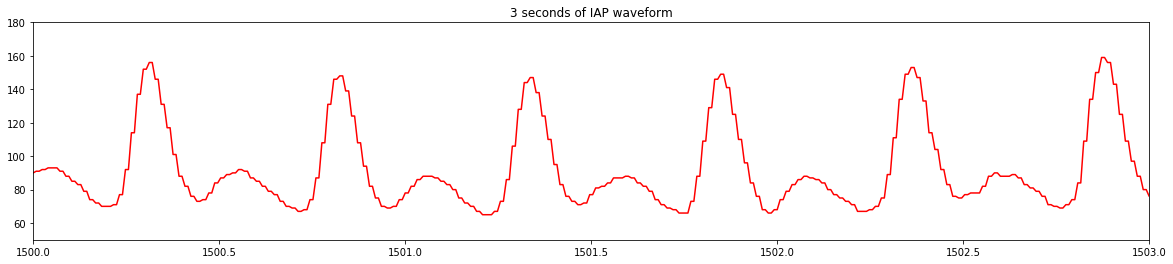

In [580]:
ibp = []
timeindex = []
starttime = ""
currenttime = None
for wave_rec in wave_records:
    if not starttime and wave_rec['Waveform'][1]['WaveRec']['FrameSize'] != 0:
        starttime = wave_rec['StdHdr']['DevDateTime'].partition('T')[2]
        currenttime = pd.to_datetime(starttime)
    samples = wave_rec['Waveform'][1]['WaveRec']['UnpackedSamples']
    for sample in samples:
        timeindex.append(currenttime)
        currenttime = currenttime + timedelta(microseconds=8000)
        ibp.append(sample)

samplerate = 125 # SampleTime = 8000 μs
duration = len(ibp) / samplerate
time = np.arange(0, duration, 1 / samplerate) # time vector

fig = plt.figure(figsize=(20,4))
plt.xlim(1500, 1503)
plt.ylim(50, 180)
plt.title("3 seconds of IAP waveform")
plt.plot(time, ibp, color="red")
plt.show()

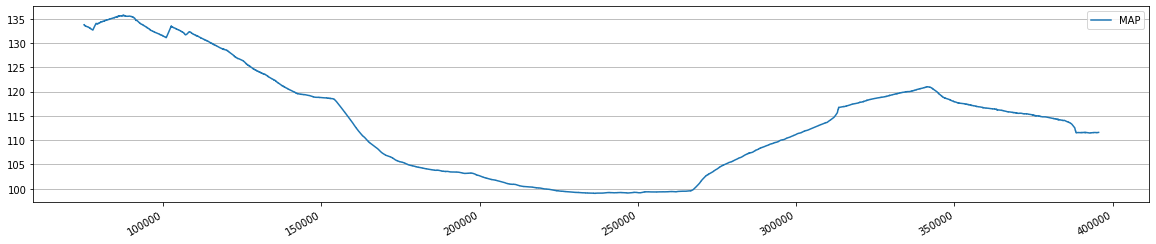

In [595]:
ibp_df = pd.DataFrame()
ibp_df['Time'] = timeindex
ibp_df['PulseWave'] = ibp
ibp_df = ibp_df.set_index('Time')
map_window = 600 # seconds
map_win = map_window * samplerate
ibp_df['MAP'] = ibp_df['PulseWave'].rolling(map_win).mean()
ibp_df[['MAP']].plot(figsize=(20,4), use_index = False).grid(axis='y')

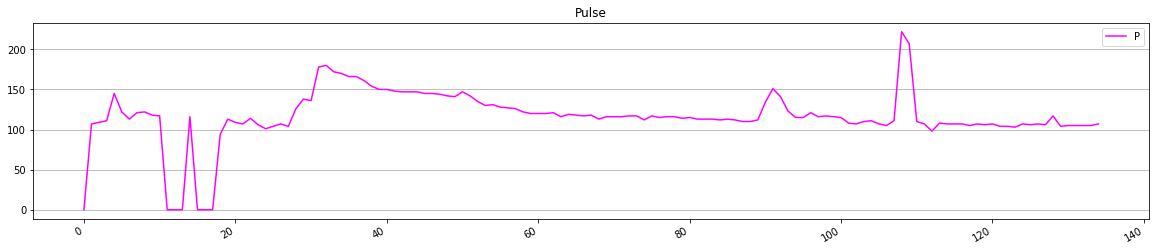

In [582]:
df[['P']].plot(figsize=(20,4), title="Pulse", color='magenta', use_index = False).grid(axis='y')

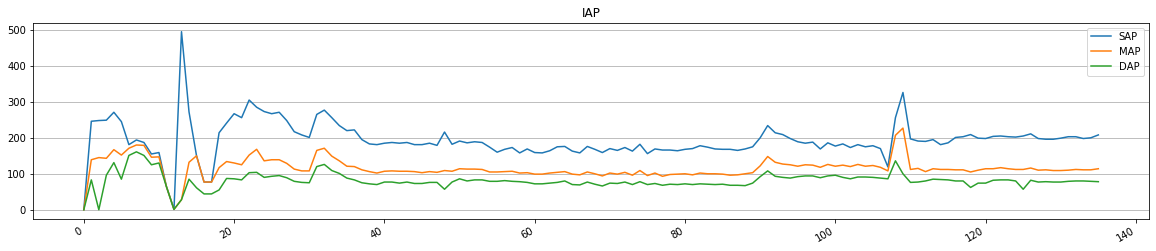

In [594]:
df[['SAP', 'MAP', 'DAP']].plot(figsize=(20,4), title="IAP", use_index = False).grid(axis='y')

In [584]:
nirs_df = pd.read_csv("data/AR18F032727-20200113-114412-690.csv", 
                      sep = ',', 
                      skiprows = 5,
                      na_values = '--',
                      parse_dates = ['Time'],
                      index_col = 'Time')
# nirs_df

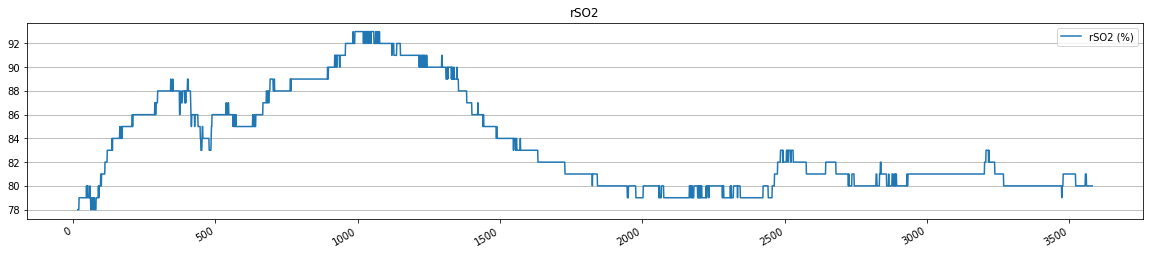

In [585]:
nirs_df[['rSO2 (%)']].plot(figsize=(20,4), title="rSO2", use_index = False).grid(axis='y')

In [586]:
nirs_df = nirs_df.join(df['MAP'])
nirs_df = nirs_df.rename(columns={'MAP': 'MAP30'}) # this is MAP in TrendRpt every 30 s.
# nirs_df

In [587]:
nirs_df = nirs_df.interpolate()
# nirs_df

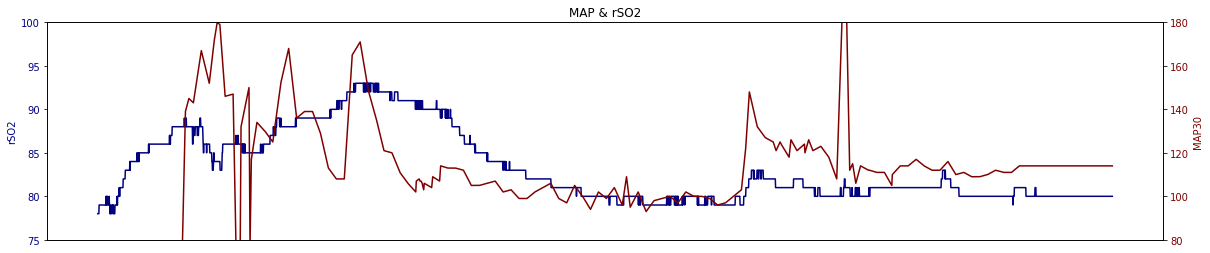

In [588]:
fig, ax1 = plt.subplots(figsize=(20,4))
ax1.set_ylabel('rSO2', color='navy')
ax1.set_ylim(75, 100)
ax1.plot(nirs_df.index, nirs_df['rSO2 (%)'], color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2 = ax1.twinx()
ax2.set_ylabel('MAP30', color='maroon')
ax2.set_ylim(80, 180)
ax2.plot(nirs_df.index, nirs_df['MAP30'], color='maroon')
ax2.tick_params(axis='y', labelcolor='maroon')
plt.title("MAP & rSO2")
plt.show()

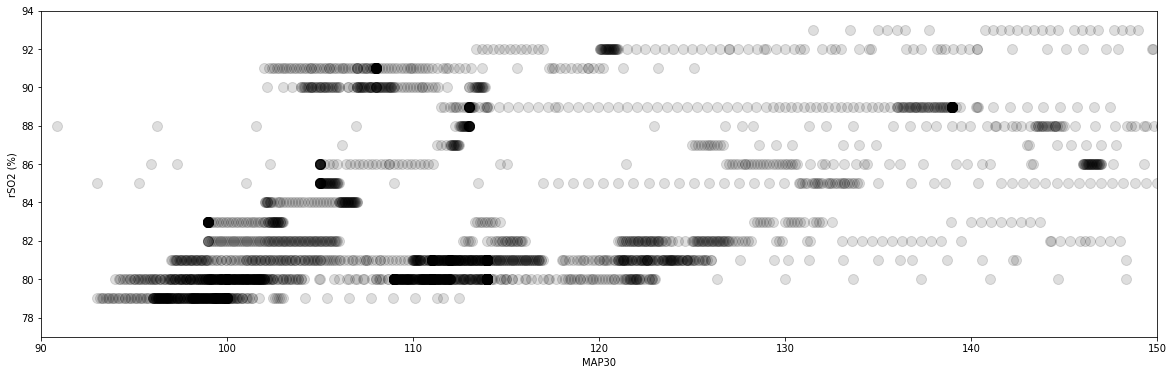

In [589]:
nirs_df.plot.scatter(x = 'MAP30', y = 'rSO2 (%)', xlim=(90,150), ylim=(77,94), figsize=(20, 6), marker='o', s=100, color='k', alpha=0.13)

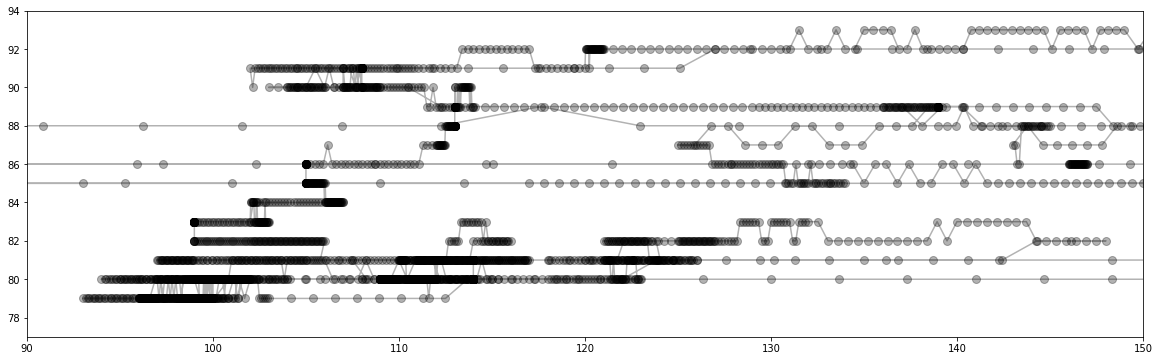

In [590]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.set_xlim((90,150))
ax1.set_ylim((77,94))
ax1.plot(nirs_df['MAP30'], nirs_df['rSO2 (%)'], 'o-', markersize=8, color='k', alpha=0.3)
plt.show()

In [591]:
nirs_df = pd.merge_asof(nirs_df, ibp_df[['MAP']], on='Time', direction='nearest')
# nirs_df

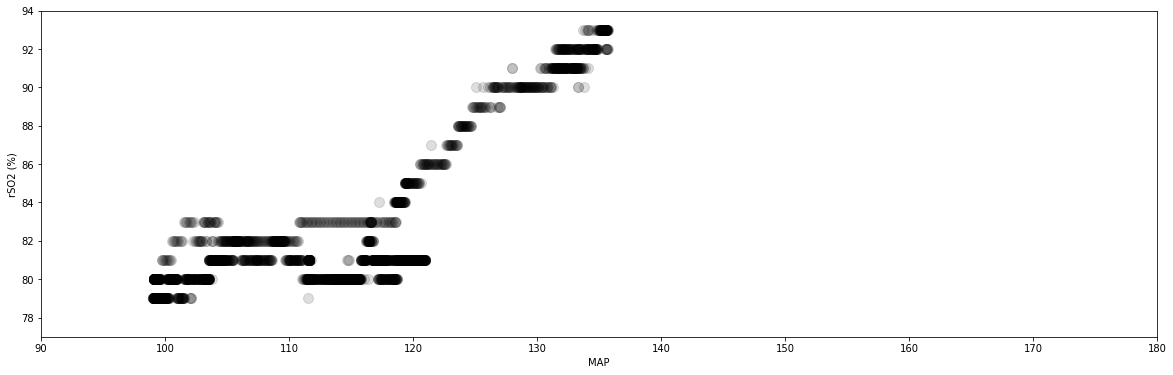

In [592]:
nirs_df.plot.scatter(x = 'MAP', y = 'rSO2 (%)', xlim=(90,180), ylim=(77,94), figsize=(20, 6), marker='o', s=100, color='k', alpha=0.13)

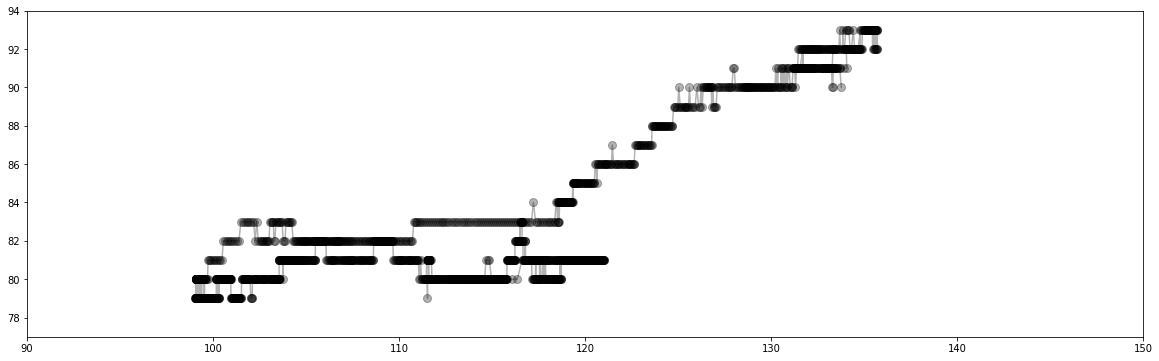

In [593]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.set_xlim((90,150))
ax1.set_ylim((77,94))
ax1.plot(nirs_df['MAP'], nirs_df['rSO2 (%)'], 'o-', markersize=8, color='k', alpha=0.3)
plt.show()